<center>
    <img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" style="width:60%">
    <h1> INF285 - Computación Científica </h1>
    <h2> Generalized Minimal Residual Method </h2>
    <h2> <a href="#acknowledgements"> [S]cientific [C]omputing [T]eam </a> </h2>
    <h2> Version: 1.23</h2>
</center>

<div id='toc' />

## Table of Contents
* [Introduction](#intro)
* [A quick review on Least Squares](#LS)
* [GMRes](#GMRes)
    * [A very simple example](#AVSE)
    * [Another example, how may iteration does it need to converge?](#AEx)
    * [Plotting the residual over the iterations](#Proi)
* [Theoretical Problems](#TP)
* [Practical Problems](#PP)
* [Acknowledgements](#acknowledgements)

In [1]:
import numpy as np
import scipy as sp
from scipy import linalg as la
import matplotlib.pyplot as plt
import scipy.sparse.linalg
%matplotlib inline
#%load_ext memory_profiler
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
M=8

<div id='intro' />

## Introduction
[Back to TOC](#toc)

Welcome to another edition of our Jupyter Notebooks. A few notebooks back, we saw that the Conjugate Gradient Method, an iterative method, was very useful to solve $A\,\mathbf{x}=\mathbf{b}$ but it only worked when $A$ was positive definite and symmetric. So now we need an iterative method that works with nonsymmetric linear system of equations, and for that we have the Generalized Minimum Residual Method (GMRes). It works really well for finding the solution of large, sparse (and dense as well), nonsymmetric linear systems of equations. Of course, it will also have trouble for ill-conditioned linear system of equations. But it is really easy to add a left or right or both preconditioners!

<div id='LS' />

## A quick review on Least Squares
[Back to TOC](#toc)

Least Squares is used to solve overdetemined linear systems of equations $A\,\mathbf{x} = \mathbf{b}$. That is, for example, a linear system of equations where there are more equations than unknowns. It finds the _best_ $\overline{\mathbf{x}}$ so that it minimizes the euclidean length of $\mathbf{r} = \mathbf{b} - A\,\mathbf{x}$.

So, you might be wondering, what does Least Squares have to do with GMRes? WELL, since you're dying to know, I'll tell you: the backward error of the system in GMRes is minimized at each iteration step using a Least Squares formulation.

<div id='GMRes' />

## GMRes
[Back to TOC](#toc)

GMRes is a member of the family of Krylov methods.
It solve a square linear system of equations $A\,\mathbf{x}=\mathbf{b}$, for $A\in\mathbb{R}^{n \times n}$ nonsingular, $\mathbf{x}\in\mathbb{R}^n$ and $\mathbf{b}\in\mathbb{R}^n$.
It finds an approximation of $\mathbf{x}$ restricted to _live_ on the Krylov sub-space $\mathcal{K}_k$,  where $\mathcal{K}_k=\{\mathbf{r}_0, A\,\mathbf{r}_0, A^2\,\mathbf{r}_0, \cdots, A^{k-1}\,\mathbf{r}_0\}$ and $\mathbf{r}_0 = \mathbf{b} - A\,\mathbf{x}_0$ is the residual vector of the initial guess.

The idea behind this method is to look for improvements to the initial guess $\mathbf{x}_0$ in the Krylov sub-space. 
At the $(k+1)$-th iteration, we enlarge the Krylov space by adding $A^k\,\mathbf{r}_0$, reorthogonalize it against  the basis, and then use least squares to find the best improvement to add to $\mathbf{x}_0$.

The algorithm is as follows:

`Generalized Minimum Residual Method`

$\mathbf{x}_0$ `= initial guess`<br>
$\mathbf{r}$ `=` $\mathbf{b} - A\,\mathbf{x}_0$<br>
$\mathbf{q}_1$ `=` $\mathbf{r} / \|\mathbf{r}\|_2$<br>
`for` $k = 1, ..., n$<br>
$\qquad \ \ \mathbf{y} = A\,\mathbf{q}_k$<br>
$\qquad$ `for` $j = 1,2,...,k$ <br>
$\qquad \qquad$ $h_{jk} = \mathbf{q}_j^*\,\mathbf{y}$<br>
$\qquad \qquad$ $\mathbf{y} = \mathbf{y} - h_{jk}\, \mathbf{q}_j$<br>
$\qquad$ `end`<br>
$\qquad h_{k+1,k} = \|\mathbf{y}\|_2$ <br>
$\qquad$ `if` $h_{k+1,k}>0:$ <br>
$\qquad \qquad\ \mathbf{q}_{k+1} = \mathbf{y}/h_{k+1,k}$ <br>
$\qquad \overline{\mathbf{c}}_k=\text{argmin}_{\mathbf{c}_k}\left\|[\|\mathbf{r}\|_2, 0, 0, \dots, 0]^T-\widehat{H}_k\,\mathbf{c}_k\right\|_2$ <br>
$\qquad$ $\mathbf{x}_k = Q_k \, \overline{\mathbf{c}}_k + \mathbf{x}_0$ <br>
`end`

Now we have to implement it.

In [2]:
# This is a very instructive implementation of GMRes.
def GMRes(A, b, x0=np.array([0.0]), m=10, flag_display=True, threshold=1e-12):
    n = len(b)
    if len(x0)==1:
        x0=np.zeros(n)
    r0 = b - np.dot(A, x0)
    nr0=np.linalg.norm(r0)
    out_res=np.array(nr0)
    Q = np.zeros((n,n))
    H = np.zeros((n,n))
    Q[:,0] = r0 / nr0
    flag_break=False
    for k in np.arange(np.min((m,n))):
        y = np.dot(A, Q[:,k])
        if flag_display:
            print('||y||=',np.linalg.norm(y))
        for j in np.arange(k+1):
            H[j][k] = np.dot(Q[:,j], y)
            if flag_display:
                print('H[',j,'][',k,']=',H[j][k])
            y = y - np.dot(H[j][k],Q[:,j])
            if flag_display:
                print('||y||=',np.linalg.norm(y))
        # All but the last equation are treated equally. Why?
        if k+1<n:
            H[k+1][k] = np.linalg.norm(y)
            if flag_display:
                print('H[',k+1,'][',k,']=',H[k+1][k])
            if (np.abs(H[k+1][k]) > 1e-16):
                Q[:,k+1] = y/H[k+1][k]
            else:
                print('flag_break has been activated')
                flag_break=True
            # Do you remember e_1? The canonical vector.
            e1 = np.zeros((k+1)+1)        
            e1[0]=1
            H_tilde=H[0:(k+1)+1,0:k+1]
        else:
            H_tilde=H[0:k+1,0:k+1]
        # Solving the 'SMALL' least square problem. 
        # This could be improved with Givens rotations!
        ck = np.linalg.lstsq(H_tilde, nr0*e1,rcond=None)[0] 
        if k+1<n:
            x = x0 + np.dot(Q[:,0:(k+1)], ck)
        else:
            x = x0 + np.dot(Q, ck)
        # Why is 'norm_small' equal to 'norm_full'?
        norm_small=np.linalg.norm(np.dot(H_tilde,ck)-nr0*e1)
        out_res = np.append(out_res,norm_small)
        if flag_display:
            norm_full=np.linalg.norm(b-np.dot(A,x))
            print('..........||b-A\,x_k||=',norm_full)
            print('..........||H_k\,c_k-nr0*e1||',norm_small);
        if flag_break:
            if flag_display: 
                print('EXIT: flag_break=True')
            break
        if norm_small<threshold:
            if flag_display:
                print('EXIT: norm_small<threshold')
            break
    return x, out_res

<div id='AVSE' />

## A very simple example
[Back to TOC](#toc)

In [3]:
A = np.array([[1,1,0],[0,1,0],[0,1,1]])
b = np.array([1,2,3])
x0 = np.zeros(3)

In [4]:
# scipy gmres
x_scipy = scipy.sparse.linalg.gmres(A,b,x0)[0]
# our gmres
x_our, _ = GMRes(A,b)
# numpy solve
x_np= np.linalg.solve(A,b)

# Showing the solutions
print('--------------------------------')
print('x_scipy',x_scipy)
print('x_our',x_our)
print('x_np',x_np)

||y||= 1.647508942095828
H[ 0 ][ 0 ]= 1.5714285714285714
||y||= 0.4948716593053935
H[ 1 ][ 0 ]= 0.4948716593053935
..........||b-A\,x_k||= 1.1239029738980326
..........||H_k\,c_k-nr0*e1|| 1.1239029738980326
||y||= 0.7867957924694432
H[ 0 ][ 1 ]= -0.6598288790738581
||y||= 0.4285714285714286
H[ 1 ][ 1 ]= 0.4285714285714286
||y||= 1.1443916996305594e-16
H[ 2 ][ 1 ]= 1.1443916996305594e-16
..........||b-A\,x_k||= 1.0175362097255202e-15
..........||H_k\,c_k-nr0*e1|| 4.920762688787672e-16
EXIT: norm_small<threshold
--------------------------------
x_scipy [-1.  2.  1.]
x_our [-1.  2.  1.]
x_np [-1.  2.  1.]


<div id='AEx' />

## Another example, how may iteration does it need to converge?
[Back to TOC](#toc)

In [5]:
A = np.array([[0,0,0,1],[1,0,0,0],[0,1,0,0],[0,0,1,0]])
b = np.array([1,0,1,0])
x_our, _ = GMRes(A, b, m=10)
norm_full=np.linalg.norm(b-np.dot(A,x_our))
print(norm_full)

||y||= 0.9999999999999999
H[ 0 ][ 0 ]= 0.0
||y||= 0.9999999999999999
H[ 1 ][ 0 ]= 0.9999999999999999
..........||b-A\,x_k||= 1.4142135623730951
..........||H_k\,c_k-nr0*e1|| 1.4142135623730951
||y||= 1.0
H[ 0 ][ 1 ]= 1.0
||y||= 1.5700924586837752e-16
H[ 1 ][ 1 ]= 0.0
||y||= 1.5700924586837752e-16
H[ 2 ][ 1 ]= 1.5700924586837752e-16
..........||b-A\,x_k||= 3.1401849173675503e-16
..........||H_k\,c_k-nr0*e1|| 2.2204460492503136e-16
EXIT: norm_small<threshold
3.1401849173675503e-16


In [6]:
A = np.random.rand(10,10)+10*np.eye(10)
b = np.random.rand(10)
x_our, out_res = GMRes(A, b, m=10,flag_display=True, threshold=1e-15)
norm_full=np.linalg.norm(b-np.dot(A,x_our))
print(norm_full)

||y||= 13.392381686810994
H[ 0 ][ 0 ]= 13.18819782293616
||y||= 2.3296620845806078
H[ 1 ][ 0 ]= 2.3296620845806078
..........||b-A\,x_k||= 0.23114637573612035
..........||H_k\,c_k-nr0*e1|| 0.23114637573612035
||y||= 11.16601272009107
H[ 0 ][ 1 ]= 2.1176478966387604
||y||= 10.963366611178202
H[ 1 ][ 1 ]= 10.947895247078291
||y||= 0.5822345833918966
H[ 2 ][ 1 ]= 0.5822345833918966
..........||b-A\,x_k||= 0.012904694797718117
..........||H_k\,c_k-nr0*e1|| 0.012904694797718075
||y||= 10.303739986496012
H[ 0 ][ 2 ]= 0.7138481677568855
||y||= 10.278982367078319
H[ 1 ][ 2 ]= -0.11007093168603133
||y||= 10.27839301120096
H[ 2 ][ 2 ]= 10.25067412428374
||y||= 0.754349315930305
H[ 3 ][ 2 ]= 0.754349315930305
..........||b-A\,x_k||= 0.0009473742991656015
..........||H_k\,c_k-nr0*e1|| 0.0009473742991655807
||y||= 9.9869235397381
H[ 0 ][ 3 ]= -0.05889443921407447
||y||= 9.986749883400737
H[ 1 ][ 3 ]= -0.5114767989579354
||y||= 9.973643502638962
H[ 2 ][ 3 ]= -0.21163422598024392
||y||= 9.97139787954

<div id='Proi' />

## Plotting the residual over the iterations
[Back to TOC](#toc)

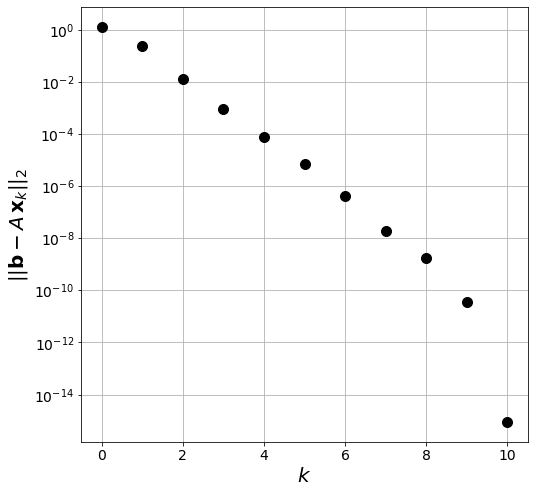

In [7]:
plt.figure(figsize=(M,M))
plt.semilogy(out_res,'.k',markersize=20,label='residual')
plt.grid(True)
plt.xlabel(r'$k$')
plt.ylabel(r'$\|\|\mathbf{b}-A\,\mathbf{x}_k\|\|_2$')
plt.grid(True)
plt.show()

<div id='TP' />

## Theoretical Problems
[Back to TOC](#toc)

1. Prove that in GMRES method, the backward error $||b- Ax_k||$ decreases monotonically with k.
2. What would happen if we pass a singular matrix $A$ to the previous implementation of GMRes?
3. Prove that for
\begin{equation}
A=
\left[
\begin{array}{c|c}
I & C \\
\hline
0 & I
\end{array}
\right]
\end{equation}
and any $x_0$ and $b$, GMRES converges to the exact solution after **two** steps. Here $C$ is a $m_1 \times m_2$ submatrix, $0$ denotes the $m_2 \times m_1$ matrix of zeros, and $I$ denotes the appropiate-sized identity matrix.

<div id='PP' />

## Practical Problems
[Back to TOC](#toc)

1. A possible improvement to the present algorithm consists on taking out of the loop the least squares computations, since the _Krylov_ subspace spaned by $Q_k$ doesn't depend on previous least squares calculations.
    * Verify the truth of the above statement.
    * Verify if it is really an improvement.
    * Implement it.
    * Test both implementations using `%timeit`
1. The GMRES method is meant for huge $n\times n$ sparse matrices $A$. In most cases, the goal is to run the method for $k$ steps (with $k << n$), reducing the complexity of the subproblems (Least squares). Neverthless for $k$ values too small, the solution $x_k$ could be not as good as needed. So to keep the values $k$ small and avoid bad solutions, there exists a variation of the algorithm known as **Restarted GMRES**: If no enough progress is made toward the solution after $k$ iterations, discard $Q_k$ and start GMRES from the beginning, using the current best guess $x_k$ as the new $x_0$.
    * Implement the Restarted GMRES method. Introduce a tolerance parameter to stop restarting.
    * Compare the asymptotic operation count and storage requirements of GMRES and Restarted GMRES, for fixed $k$ and increasing $n$.
    * Execute it on a _huge_ linear system $A x = b$, and compare the solution with the solution of standard GMRES. Keep a value of $k$ small, and count how many times Restarted GMRES has to restart. Perform benchmarks using `%timeit` and `%memit` and verify the results.
    * Describe an example in which Restared GMRES can be expected to fail to converge, whereas GMRES succeds.

<div id='acknowledgements' />

# Acknowledgements
[Back to TOC](#toc)

* _Material created by professor Claudio Torres_ (`ctorres@inf.utfsm.cl`) _and assistants: Laura Bermeo, Alvaro Salinas, Axel Simonsen and Martín Villanueva. DI UTFSM. April 2016._
* _Material updated by professor Claudio Torres_ (`ctorres@inf.utfsm.cl`). DI UTFSM. June 2017.
* _Update July 2020 - v1.21 - C.Torres_ : Fixing formatting issues.
* _Update June 2021 - v1.22 - C.Torres_ : Updating format and adding link to TOC. Improving GMRes description. Adding `rcond=None` to  np.linalg.lstsq.
* _Update June 2022 - v1.23 - C.Torres_ : Fixing some LaTeX issues.